In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings('ignore')
import holidays
sns.color_palette("dark:#5A9_r", as_cmap=True)
from functions import convert_to_geometry
import geopandas as gpd
from shapely.geometry import Point, MultiPolygon
import PIL
import io
from wordcloud import WordCloud

## EDA 

In [59]:
data = pd.read_csv("../data/cleaned_data_01.csv",sep=',',parse_dates=['Date Created', 'Date Closed'])
data.head()

,Reference Number,Date Created,Date Closed,Request Status,Service Category,Service Code,Business Unit,Neighbourhood,Community League,Ward,Address,Lat,Long,Location,Ticket Source,Calendar Year,Count,Geometry Point,Duration
0,8006878572,2013-01-05,2013-01-07,Closed,Vandalism/Graffiti,Park Structure,Parks,GLENORA,Glenora Community League,Nakota Isga,102 AVENUE NW,53.543041,-113.549596,"(53.543040723973064, -113.54959643094784)",Phone Call,2013,1,POINT (-113.5495964309478 53.54304072397306),2 days
1,8006890973,2013-01-07,2013-01-22,Closed,Snow & Ice Maintenance,Road Snow Removal,Roadway Operations,PARSONS INDUSTRIAL,Oak Hills Community League,Karhiio,97 STREET NW,53.463115,-113.480121,"(53.46311528383212, -113.48012134685986)",Phone Call,2013,1,POINT (-113.4801213468599 53.46311528383212),15 days
2,8006897181,2013-01-08,2013-01-30,Closed,Traffic Lights & Signs,Damaged Non-Emergency Signs (i.e. Speed Limit),Traffic Engineering,EAUX CLAIRES,Evansdale Community League,tastawiyiniwak,9630 157 AVENUE NW,53.617962,-113.490432,"(53.61796182488794, -113.49043222829481)",Phone Call,2013,1,POINT (-113.4904322282948 53.61796182488794),22 days
3,8006925519,2013-01-14,2013-01-14,Closed,Snow & Ice Maintenance,Road Snow Removal,Roadway Operations,PARSONS INDUSTRIAL,Oak Hills Community League,Karhiio,97 STREET NW,53.463115,-113.480121,"(53.46311528383212, -113.48012134685986)",Phone Call,2013,1,POINT (-113.4801213468599 53.46311528383212),0 days
4,8006936182,2013-01-15,2013-01-16,Closed,Maintenance - Road Services & Repairs,PONDING:Road Flooding,Roadway Maintenance,MAYFIELD,Mayfield Community League,Nakota Isga,16306 109 AVENUE NW,53.554164,-113.602476,"(53.55416409862749, -113.60247580557123)",Phone Call,2013,1,POINT (-113.6024758055712 53.55416409862749),1 days


In [60]:
data = data[data['Calendar Year'] != 2013]

In [61]:
data.shape

(833970, 19)

In [62]:
data.dtypes

Reference Number             int64
Date Created        datetime64[ns]
Date Closed         datetime64[ns]
Request Status              object
Service Category            object
Service Code                object
Business Unit               object
Neighbourhood               object
Community League            object
Ward                        object
Address                     object
Lat                        float64
Long                       float64
Location                    object
Ticket Source               object
Calendar Year                int64
Count                        int64
Geometry Point              object
Duration                    object
dtype: object

In [63]:
data.isna().sum()

Reference Number    0
Date Created        0
Date Closed         0
Request Status      0
Service Category    0
Service Code        0
Business Unit       0
Neighbourhood       0
Community League    0
Ward                0
Address             0
Lat                 0
Long                0
Location            0
Ticket Source       0
Calendar Year       0
Count               0
Geometry Point      0
Duration            0
dtype: int64

### Correcting Data Entries

In [64]:
data['Ticket Source'].value_counts()

Ticket Source
Phone Call            443910
Mobile App            287518
Mobile App Generic     41333
ESRI MAP               28750
Email                  19277
Web Forms              13182
Name: count, dtype: int64

In [65]:
data['Ticket Source'] = data['Ticket Source'].replace({
    'Phone Call':'Calls',
    'Mobile App Generic' : 'Apps',
    'Mobile App' : 'Apps',
    'ESRI MAP':'Research',               
    'Email':'Emails'
})

In [66]:
data['Ticket Source'].value_counts()

Ticket Source
Calls        443910
Apps         328851
Research      28750
Emails        19277
Web Forms     13182
Name: count, dtype: int64

### Extract Day, Month and Year from Date Created and Date Closed Feature

In [67]:
data['Request Month'] = data['Date Created'].dt.month
data['Request Day'] = data['Date Created'].dt.day
data = data.rename(
    columns={
        'Calendar Year' : 'Request Year',
        'Duration': 'Closing Duration'
    }
)

In [68]:
data.describe().T

,count,mean,min,25%,50%,75%,max,std
Reference Number,833970.0,6060719325.443553,52041603.0,514047157.75,8017224586.5,8022292486.75,8026163419.0,3341509402.592358
Date Created,833970,2019-09-01 14:38:26.206697728,2014-01-01 00:00:00,2017-09-02 00:00:00,2019-09-11 00:00:00,2022-01-20 00:00:00,2024-07-23 00:00:00,NaN
Date Closed,833970,2019-09-20 20:20:48.079427584,2014-01-01 00:00:00,2017-09-25 00:00:00,2019-10-07 00:00:00,2022-01-29 00:00:00,2025-07-23 00:00:00,NaN
Lat,833970.0,53.526441,53.337684,53.479753,53.530516,53.570628,53.716072,0.060434
Long,833970.0,-113.505707,-113.713619,-113.55142,-113.500467,-113.451417,-113.282514,0.075248
Request Year,833970.0,2019.20742,2014.0,2017.0,2019.0,2022.0,2024.0,2.838887
Count,833970.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
Request Month,833970.0,6.051846,1.0,3.0,6.0,9.0,12.0,3.370095
Request Day,833970.0,15.733293,1.0,9.0,16.0,23.0,31.0,8.599958


In [69]:
data.dtypes

Reference Number             int64
Date Created        datetime64[ns]
Date Closed         datetime64[ns]
Request Status              object
Service Category            object
Service Code                object
Business Unit               object
Neighbourhood               object
Community League            object
Ward                        object
Address                     object
Lat                        float64
Long                       float64
Location                    object
Ticket Source               object
Request Year                 int64
Count                        int64
Geometry Point              object
Closing Duration            object
Request Month                int32
Request Day                  int32
dtype: object

### Requests by Source Type

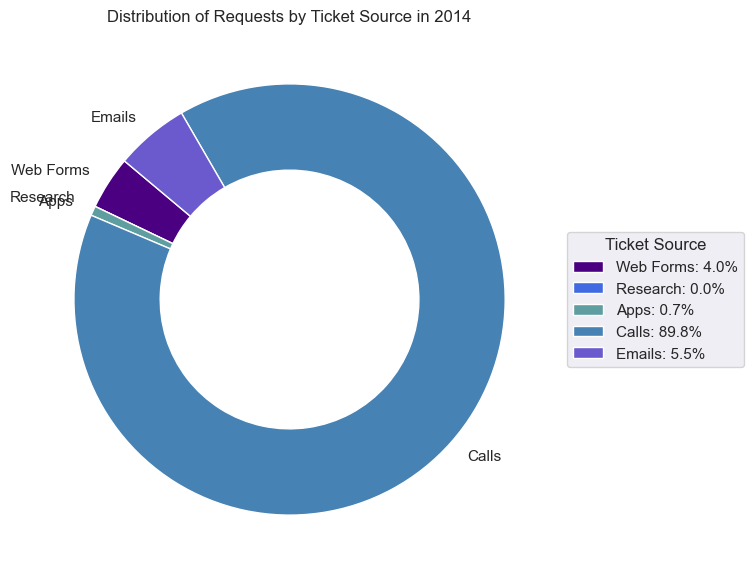

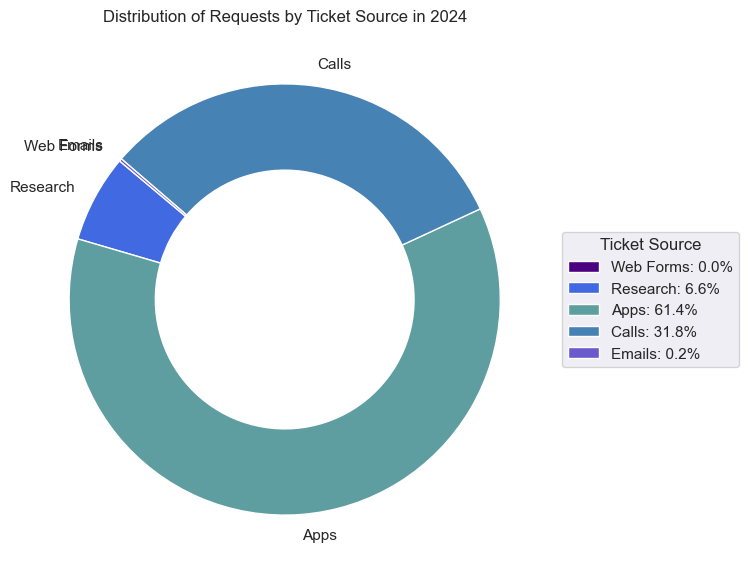

In [13]:
import matplotlib.pyplot as plt

# Filter the data for the years 2014 and 2024
data_2014 = data[data['Request Year'] == 2014]
data_2024 = data[data['Request Year'] == 2024]

# Calculate the count of each ticket source for each year
ticket_source_counts_2014 = data_2014['Ticket Source'].value_counts()
ticket_source_counts_2024 = data_2024['Ticket Source'].value_counts()

# Get the union of all ticket sources to ensure consistent color mapping
all_sources = set(ticket_source_counts_2014.index).union(ticket_source_counts_2024.index)

# Define custom colors - ensure this list has enough colors for all categories
colors = ['#4b0082', '#4169e1', '#5f9ea0', '#4682b4', '#6a5acd',
          '#7b68ee', '#483d8b', '#8a2be2', '#000080', '#191970']

# Create a mapping of ticket sources to colors
color_map = {source: colors[i % len(colors)] for i, source in enumerate(all_sources)}

# Reorder colors based on the sorted ticket sources
def get_colored_counts(ticket_source_counts):
    return [color_map[source] for source in ticket_source_counts.index]

# Plotting function
def plot_pie_chart(data_counts, year, color_map):
    sorted_counts = data_counts.reindex(color_map.keys(), fill_value=0)
    colors_for_plot = get_colored_counts(sorted_counts)
    
    fig, ax = plt.subplots(figsize=(7, 7))
    wedges, texts = ax.pie(
        sorted_counts,
        labels=sorted_counts.index,
        colors=colors_for_plot,
        startangle=140,
        wedgeprops=dict(width=0.4)  # Creates a donut chart
    )
    
    # Prepare the legend with percentages
    legend_labels = [f"{label}: {count / sorted_counts.sum() * 100:.1f}%"
                     for label, count in sorted_counts.items()]
    
    # Add the legend outside the pie chart
    ax.legend(
        legend_labels,
        title="Ticket Source",
        loc="center left",
        bbox_to_anchor=(1, 0, 0.5, 1)
    )
    
    # Customize the plot
    ax.set_title(f'Distribution of Requests by Ticket Source in {year}')
    
    # Show the plot
    plt.show()

# Plot for 2014
plot_pie_chart(ticket_source_counts_2014, 2014, color_map)

# Plot for 2024
plot_pie_chart(ticket_source_counts_2024, 2024, color_map)


***Insights :***  The Years from 2014-2019, 66.1% of the requests were coming from 

### Service Request by Business Unit

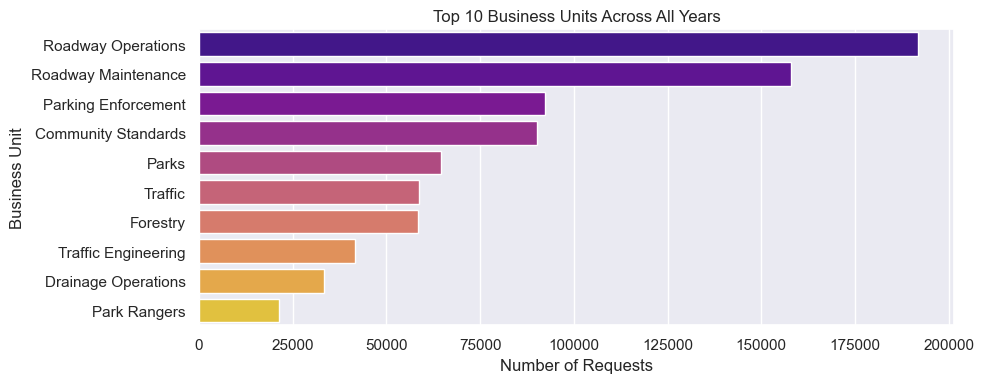

In [14]:
# Aggregate data across all years by summing the requests
aggregated_data = data.groupby('Business Unit')['Count'].sum()

# Find the top 5 departments based on the total number of requests
top_departments = aggregated_data.nlargest(10)

# Plotting
plt.figure(figsize=(10,4))
sns.barplot(y=top_departments.index,x=top_departments.values,palette='plasma')
plt.title('Top 10 Business Units Across All Years')
plt.xlabel('Number of Requests')
plt.ylabel('Business Unit')
plt.tight_layout()
plt.show()

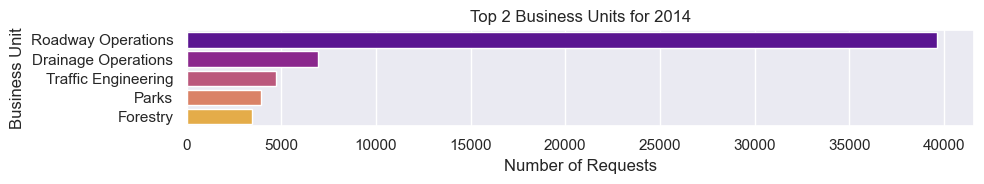

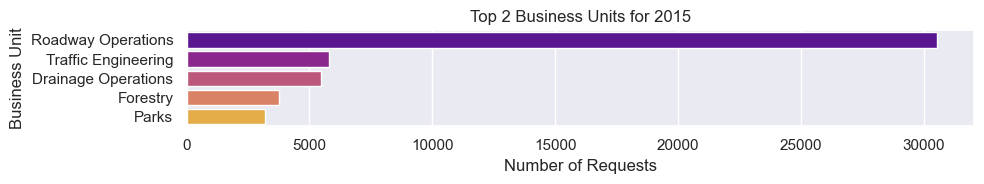

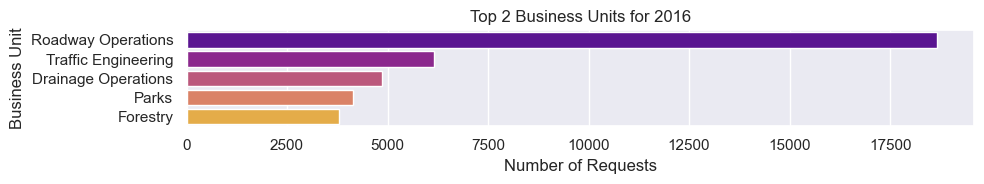

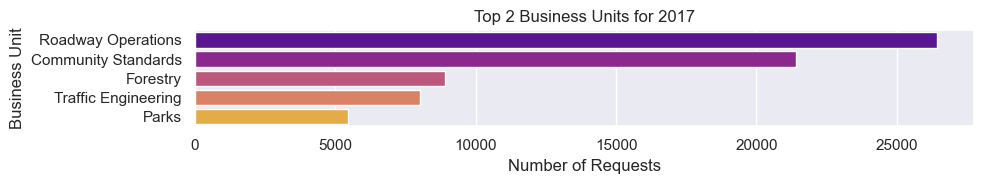

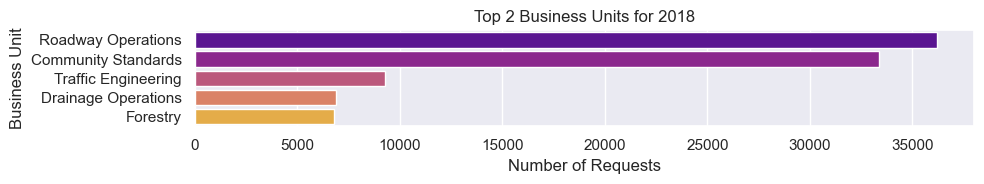

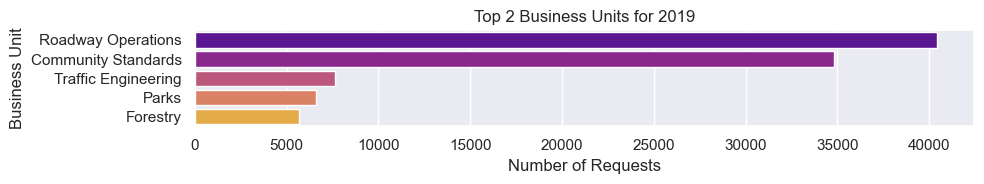

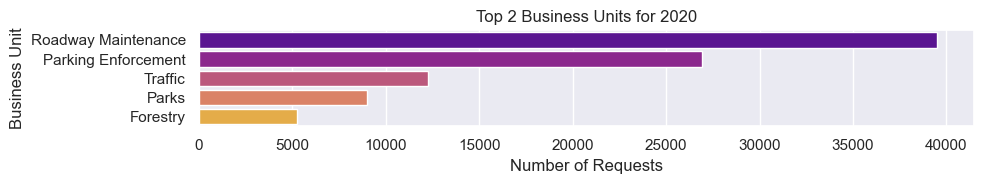

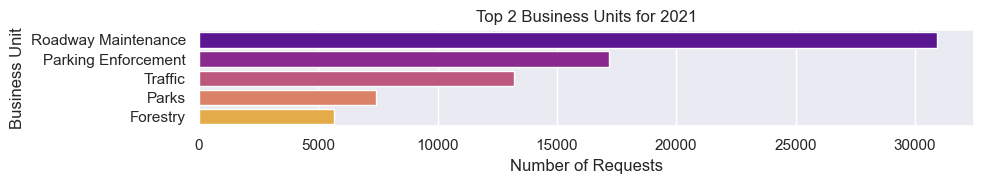

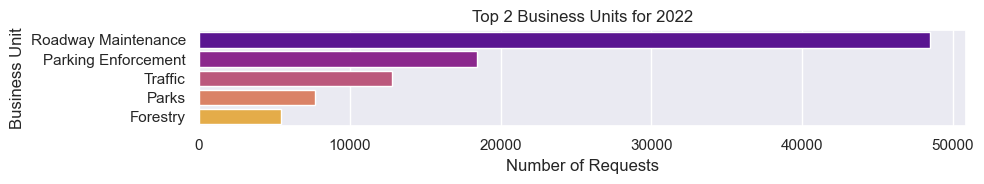

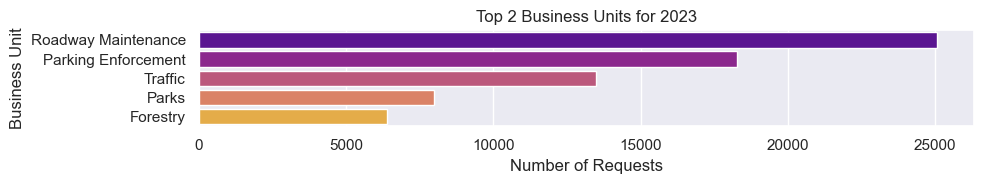

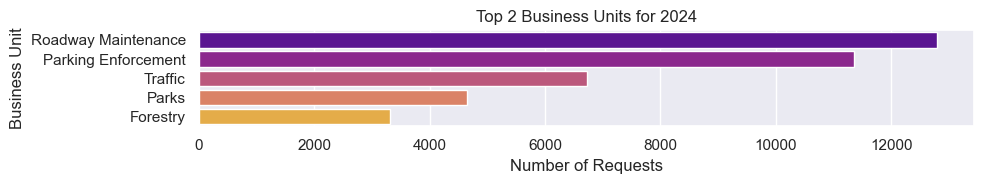

In [15]:
# Convert 'Request Year' to categorical if not already
data['Request Year'] = data['Request Year'].astype('category')

# Aggregate data by summing the requests for each business unit in each year
aggregated_data = data.groupby(['Request Year', 'Business Unit'])['Count'].sum().reset_index()

# Find the top 2 business units for each year
top_2_per_year = (aggregated_data
                   .sort_values(['Request Year', 'Count'], ascending=[True, False])
                   .groupby('Request Year')
                   .head(5))

# Unique years to plot
years = top_2_per_year['Request Year'].unique()

# Plotting
for year in years:
    plt.figure(figsize=(10,2))
    
    # Filter data for the current year
    year_data = top_2_per_year[top_2_per_year['Request Year'] == year]
    
    # Plot the data for the current year
    sns.barplot(data=year_data, x='Count', y='Business Unit', palette='plasma')
    
    plt.title(f'Top 2 Business Units for {year}')
    plt.xlabel('Number of Requests')
    plt.ylabel('Business Unit')
    plt.tight_layout()
    
    # Show plot for the current year
    plt.show()

Source Type Distribution

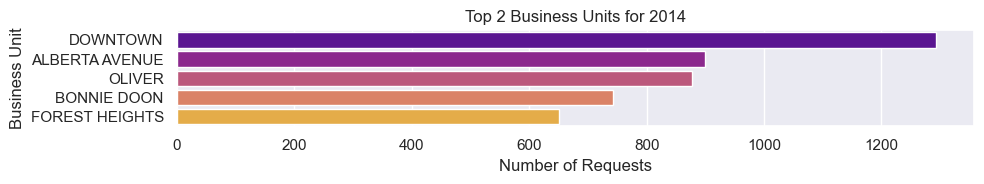

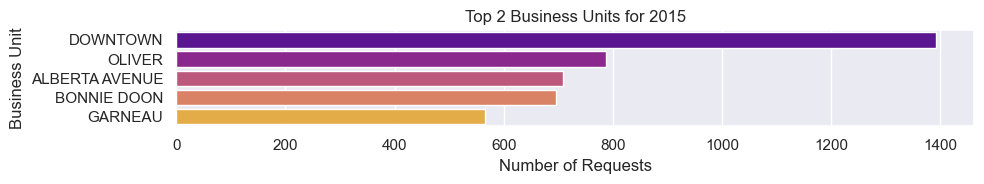

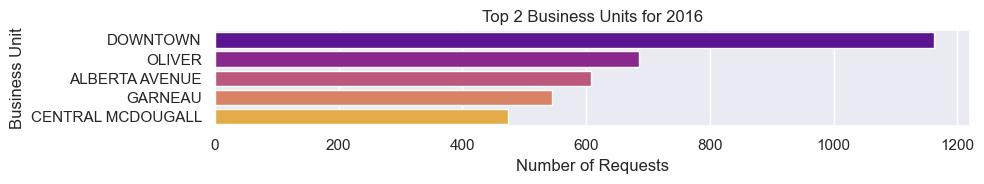

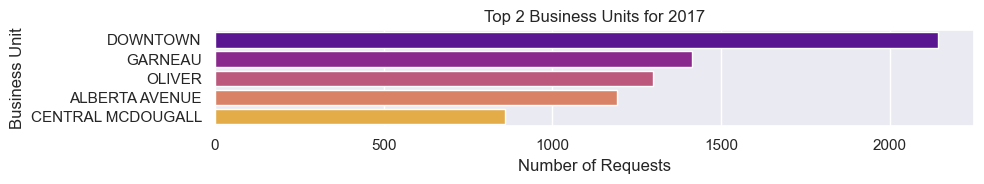

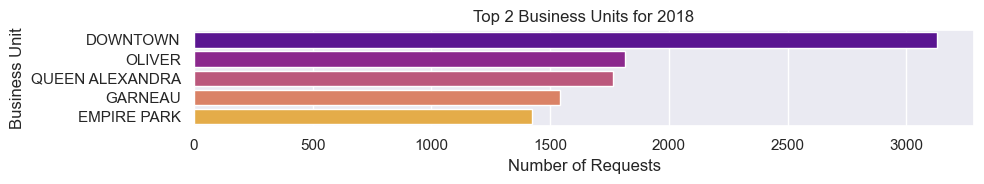

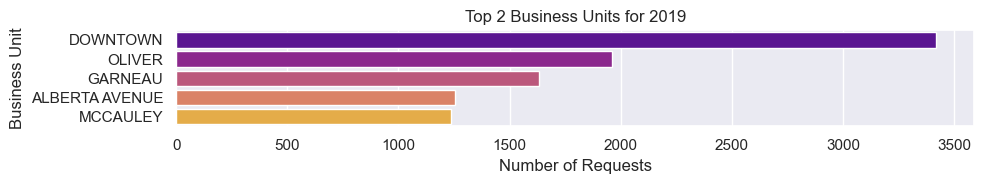

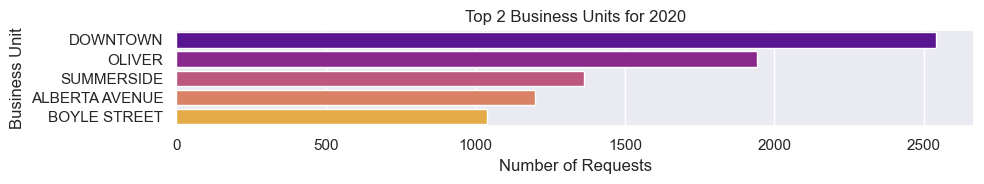

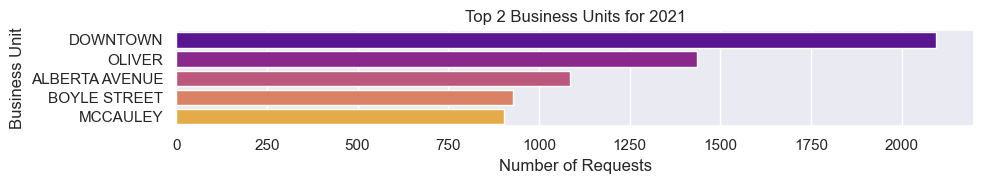

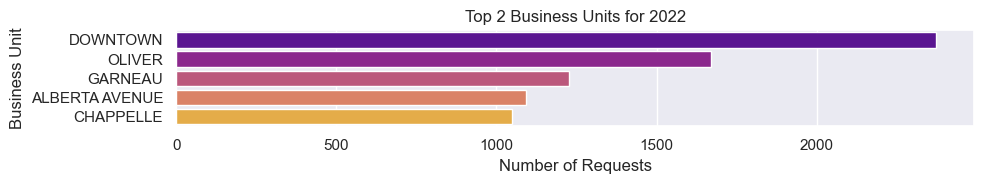

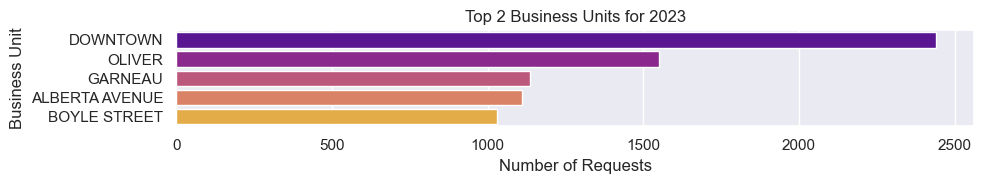

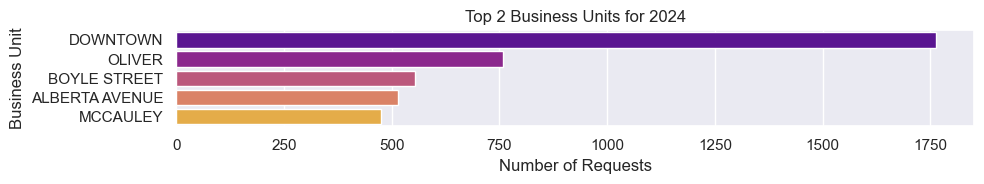

In [21]:
# Convert 'Request Year' to categorical if not already
data['Request Year'] = data['Request Year'].astype('category')

# Aggregate data by summing the requests for each business unit in each year
aggregated_data = data.groupby(['Request Year', 'Neighbourhood'])['Count'].sum().reset_index()

# Find the top 2 business units for each year
top_2_per_year = (aggregated_data
                   .sort_values(['Request Year', 'Count'], ascending=[True, False])
                   .groupby('Request Year')
                   .head(5))

# Unique years to plot
years = top_2_per_year['Request Year'].unique()

# Plotting
for year in years:
    plt.figure(figsize=(10,2))
    
    # Filter data for the current year
    year_data = top_2_per_year[top_2_per_year['Request Year'] == year]
    
    # Plot the data for the current year
    sns.barplot(data=year_data, x='Count', y='Neighbourhood', palette='plasma')
    
    plt.title(f'Top 2 Business Units for {year}')
    plt.xlabel('Number of Requests')
    plt.ylabel('Business Unit')
    plt.tight_layout()
    
    # Show plot for the current year
    plt.show()

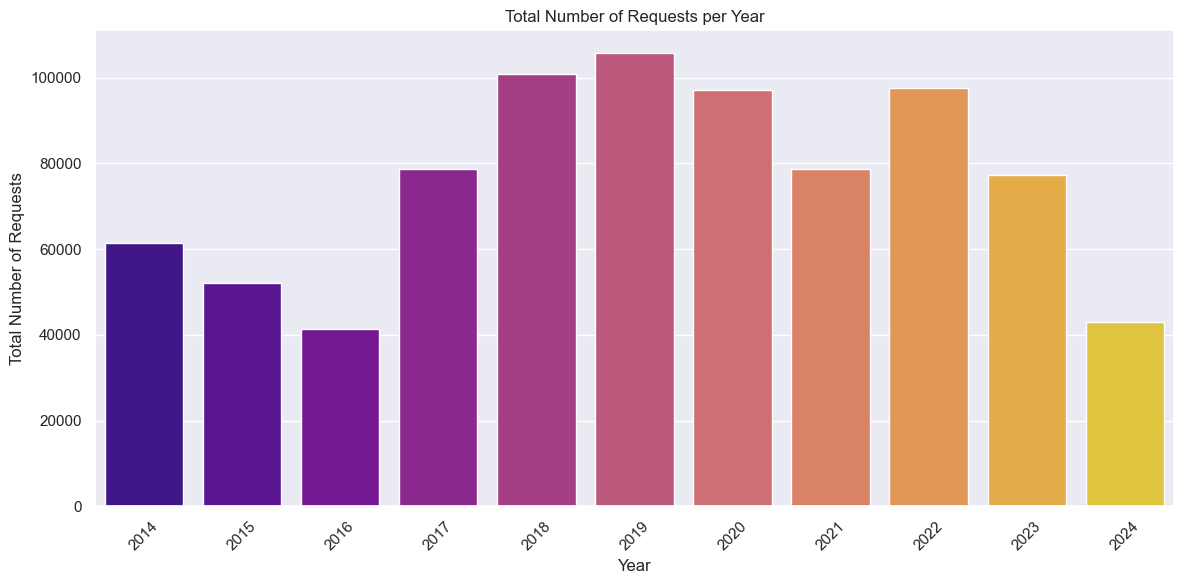

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'Request Year' to categorical if not already
data['Request Year'] = data['Request Year'].astype('category')

# Aggregate data by summing the requests for each year
annual_requests = data.groupby('Request Year')['Count'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=annual_requests, x='Request Year', y='Count', palette='plasma')

plt.title('Total Number of Requests per Year')
plt.xlabel('Year')
plt.ylabel('Total Number of Requests')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed for better readability
plt.tight_layout()

# Show the plot
plt.show()


Average number of requests per year

In [23]:
data['Request Year'] = data['Request Year'].astype('category')

# Aggregate data by summing the requests for each year
total_requests_per_year = data.groupby('Request Year')['Count'].sum().reset_index()

# Calculate the average number of requests per year
average_requests_per_year = total_requests_per_year['Count'].mean()

# Printing
print(f"Average number of requests per year: {average_requests_per_year:.2f}")

Average number of requests per year: 75815.45


Top 5 Business units in 'DOWNTOWN' for each year

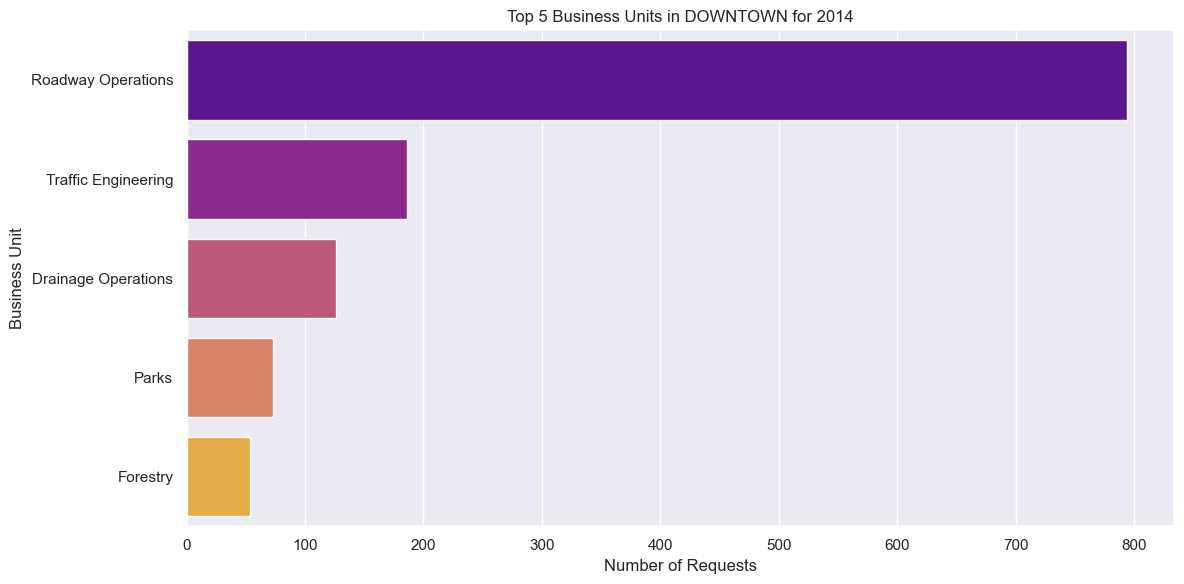

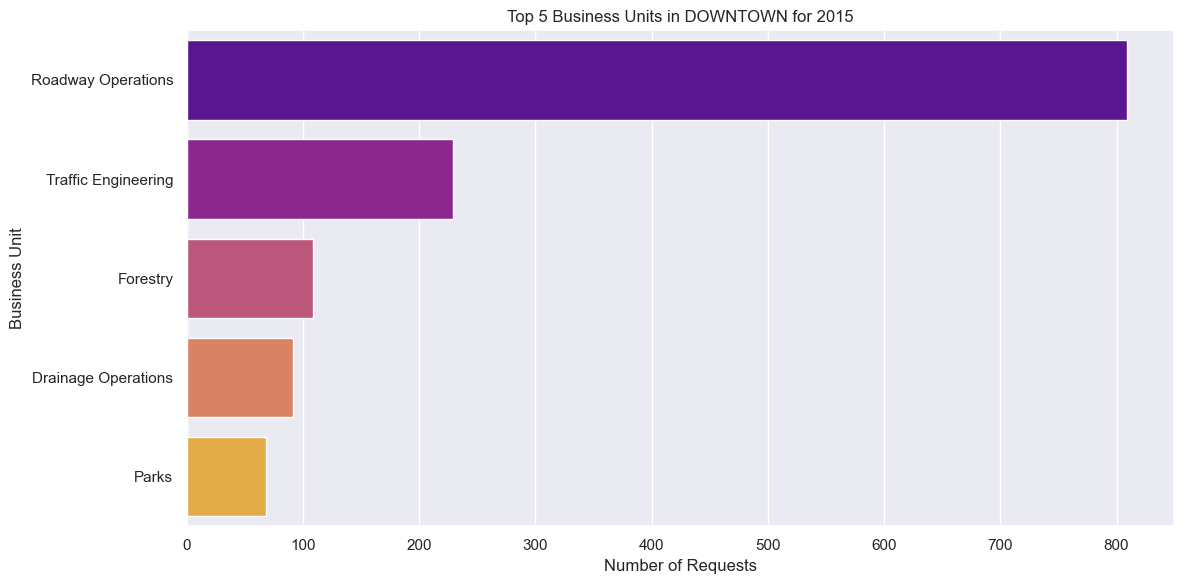

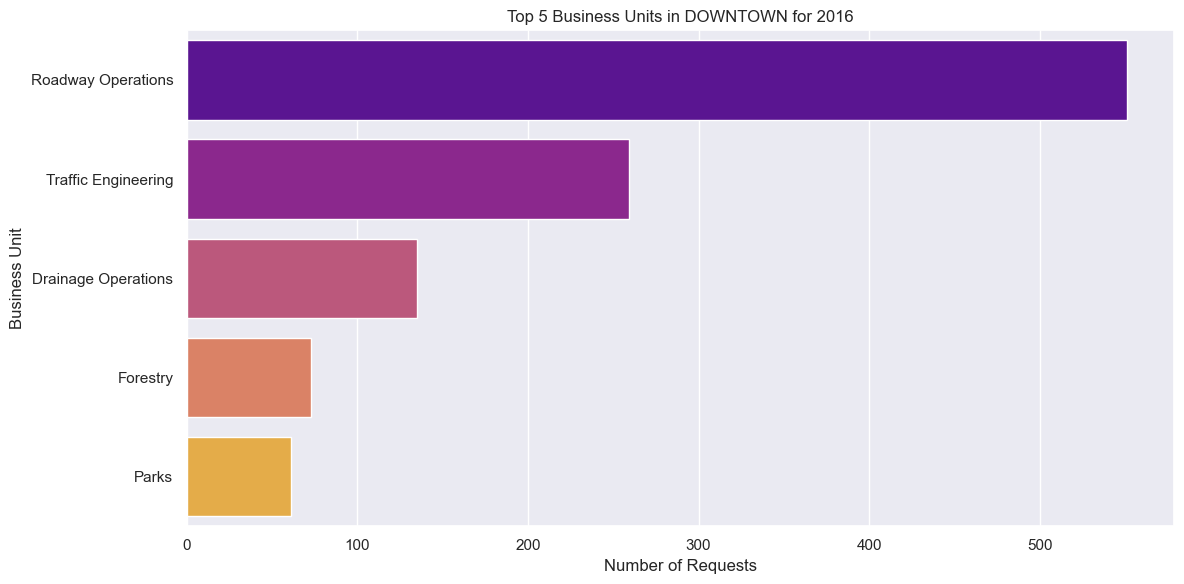

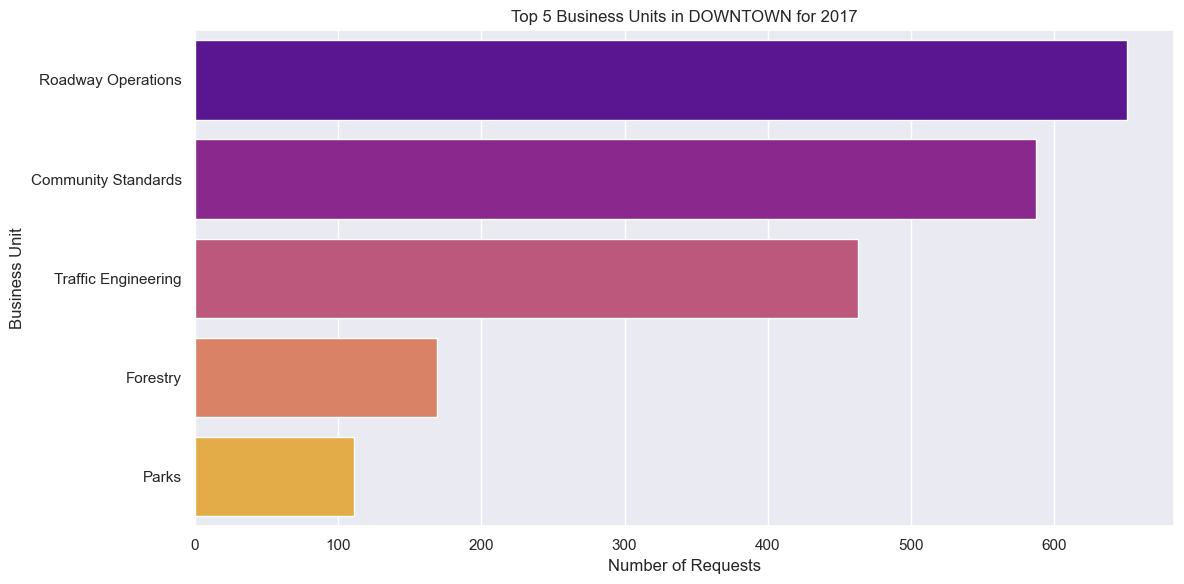

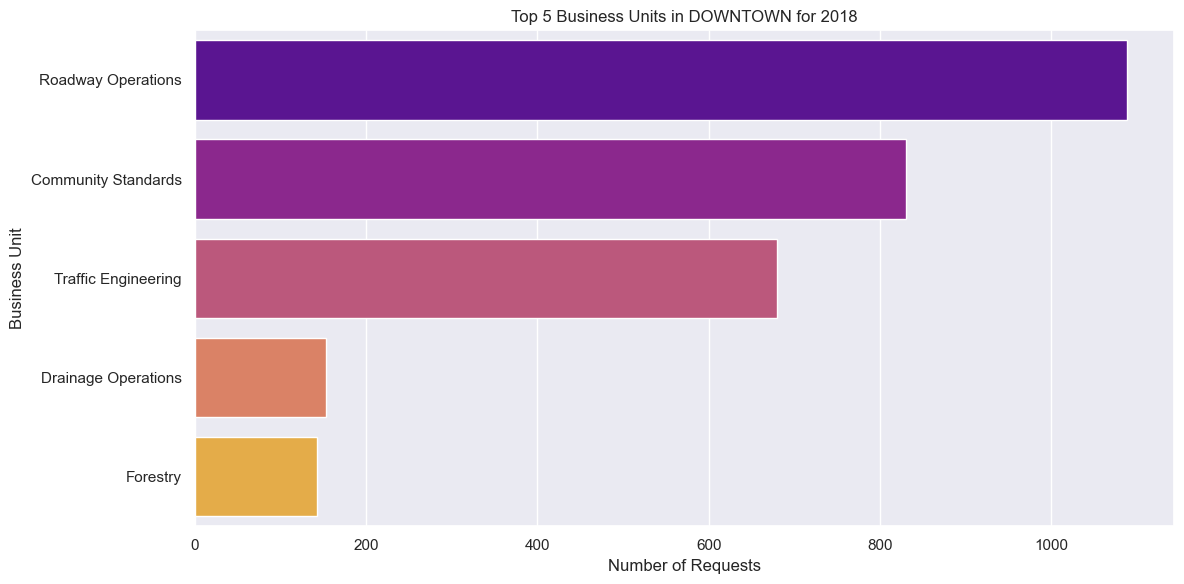

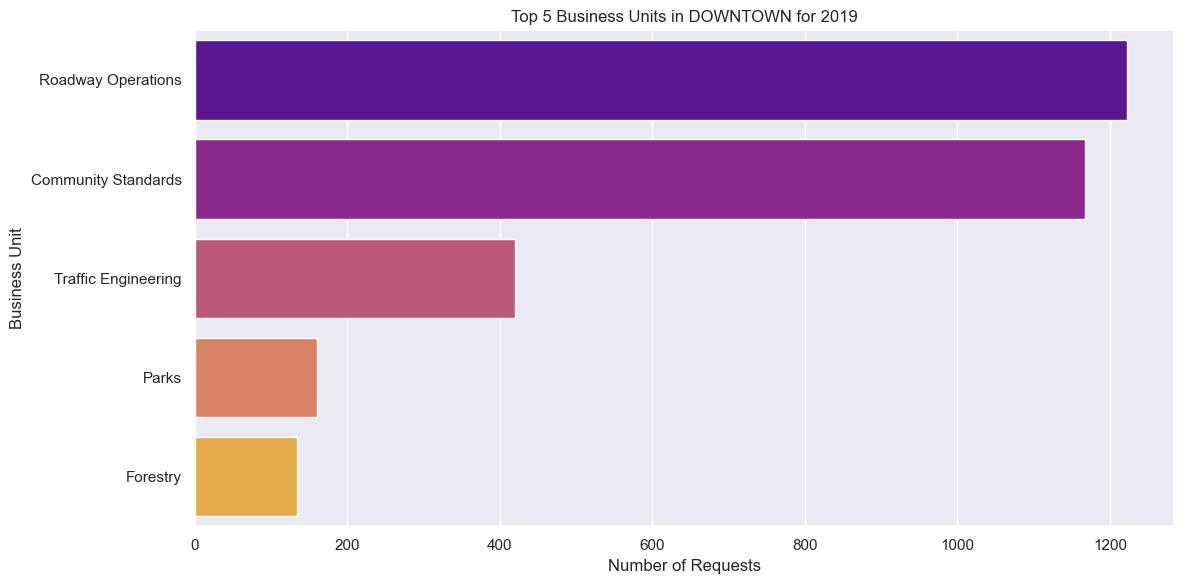

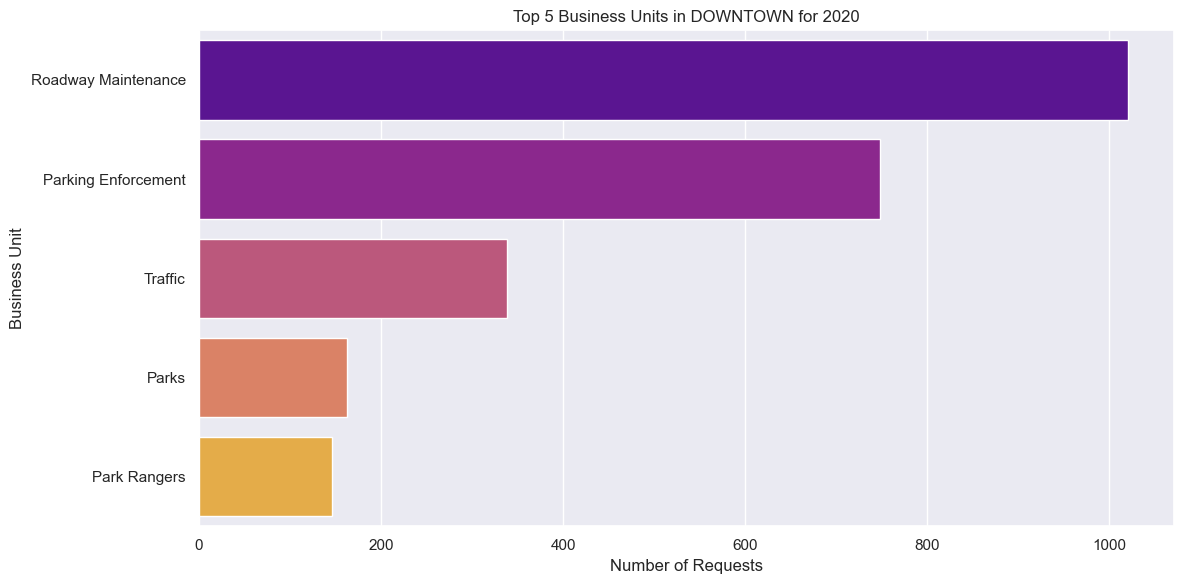

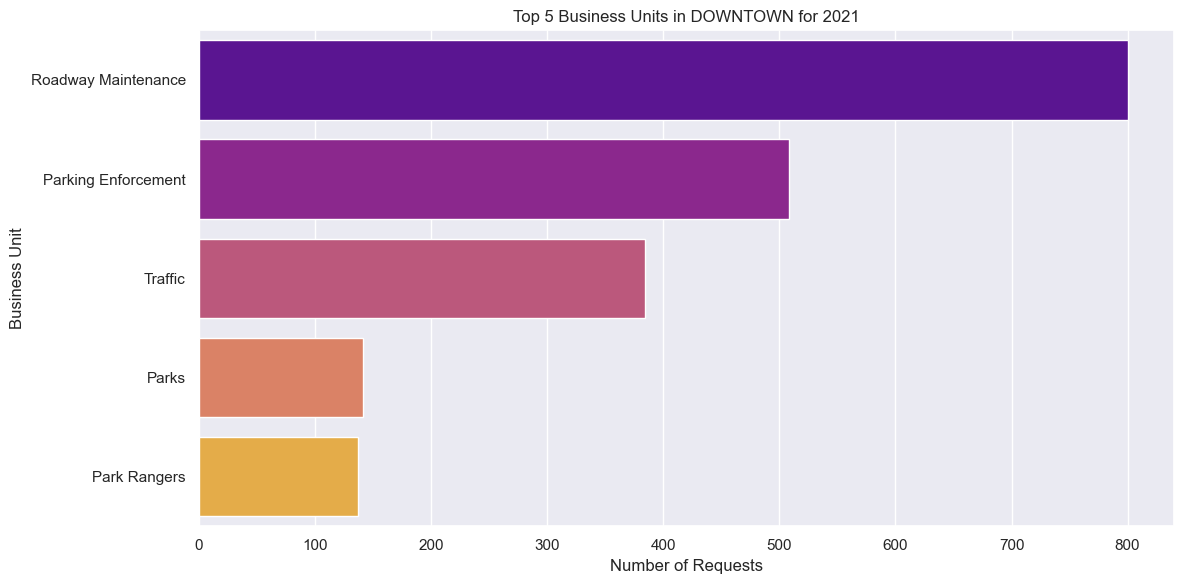

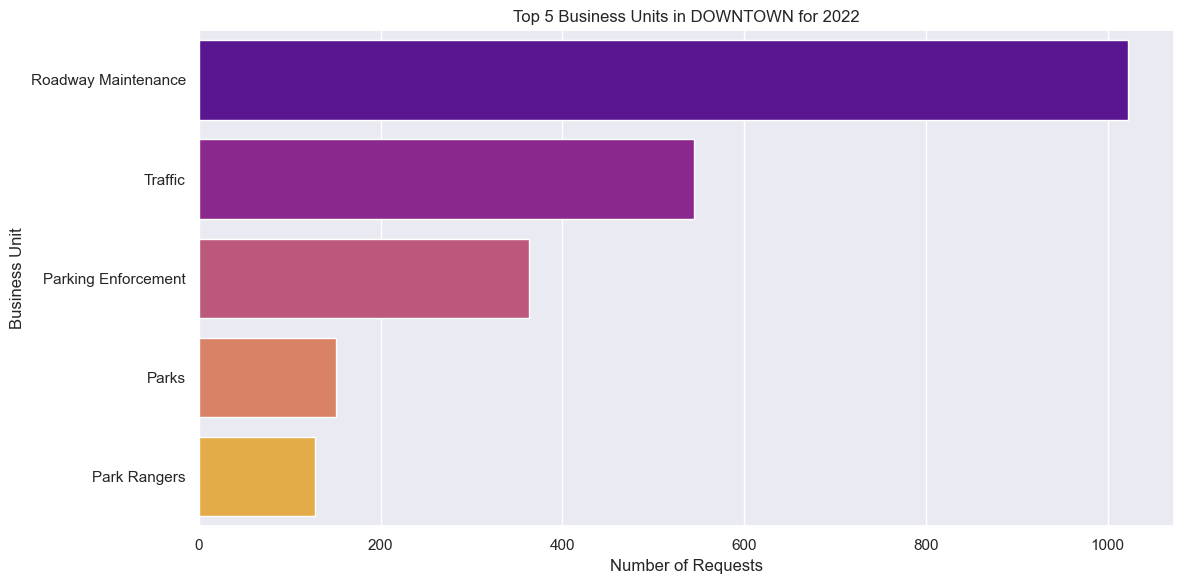

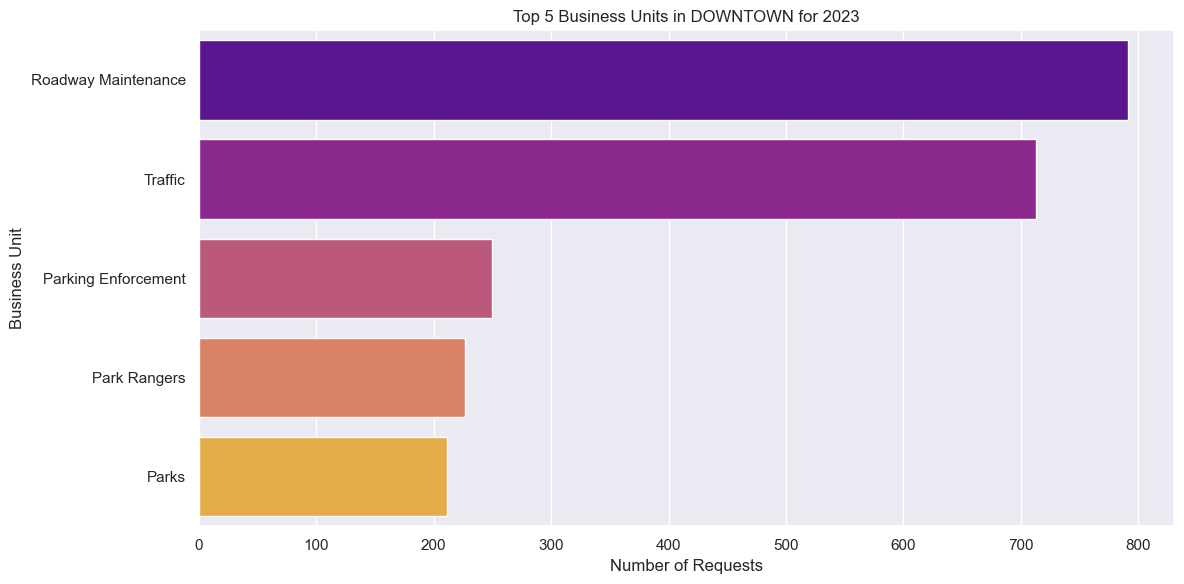

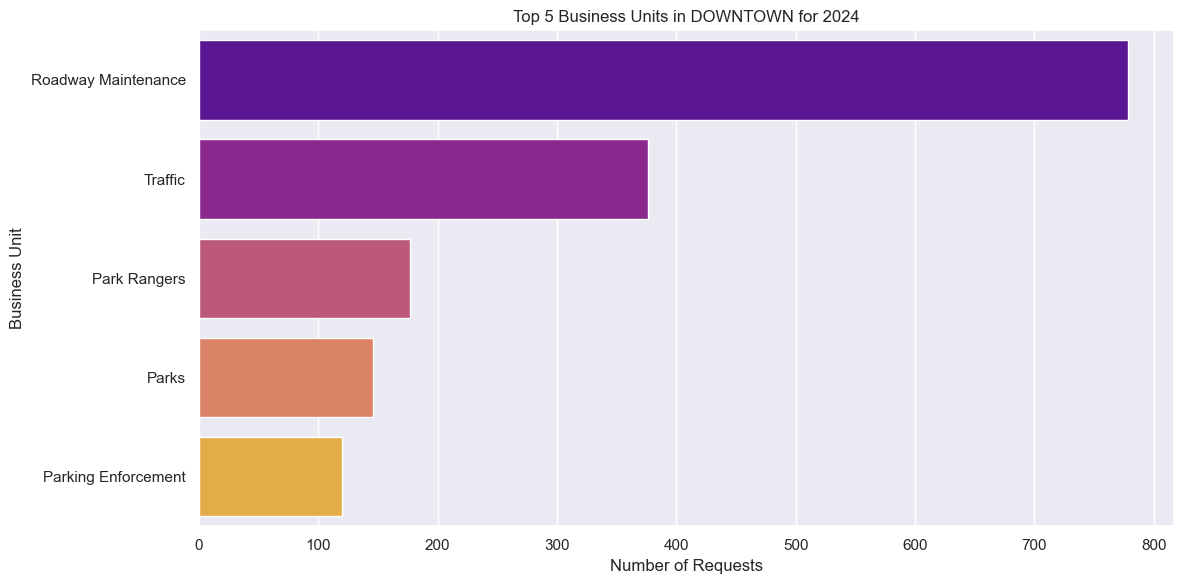

In [24]:
# Filter data for the 'DOWNTOWN' neighborhood
data_filtered = data[data['Neighbourhood'] == 'DOWNTOWN']

# Convert 'Request Year' to categorical if not already
data_filtered['Request Year'] = data_filtered['Request Year'].astype('category')

# Aggregate data by summing the requests for each business unit in each year
aggregated_data = data_filtered.groupby(['Request Year', 'Business Unit'])['Count'].sum().reset_index()

# Find the top 5 business units for each year
top_5_per_year = (aggregated_data
                   .sort_values(['Request Year', 'Count'], ascending=[True, False])
                   .groupby('Request Year')
                   .head(5))

# Unique years to plot
years = top_5_per_year['Request Year'].unique()

# Plotting
for year in years:
    plt.figure(figsize=(12, 6))
    
    # Filter data for the current year
    year_data = top_5_per_year[top_5_per_year['Request Year'] == year]
    
    # Plot the data for the current year
    sns.barplot(data=year_data, x='Count', y='Business Unit', palette='plasma')
    
    plt.title(f'Top 5 Business Units in DOWNTOWN for {year}')
    plt.xlabel('Number of Requests')
    plt.ylabel('Business Unit')
    plt.tight_layout()
    
    # Show plot for the current year
    plt.show()

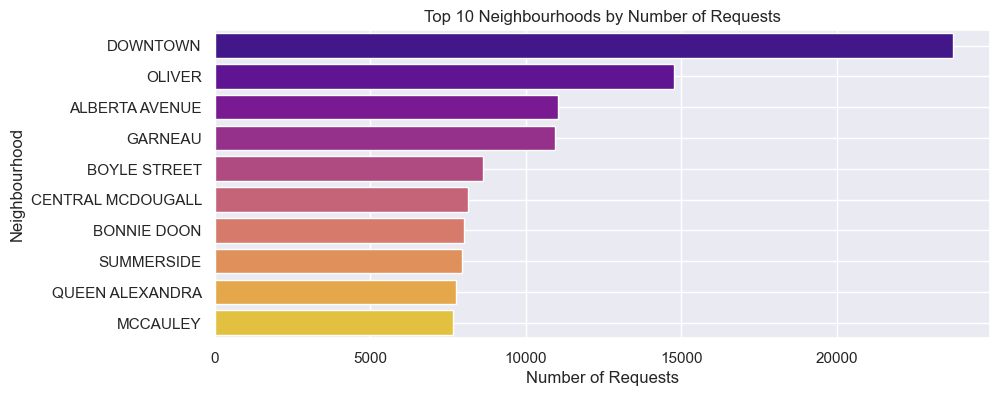

In [25]:
top_neighbourhoods = data['Neighbourhood'].value_counts().head(10)

plt.figure(figsize=(10,4))
sns.barplot(y=top_neighbourhoods.index, x=top_neighbourhoods.values, palette='plasma',orient='h')
plt.xticks()
plt.title('Top 10 Neighbourhoods by Number of Requests')
plt.xlabel('Number of Requests')
plt.ylabel('Neighbourhood')
plt.grid(True)
plt.show()

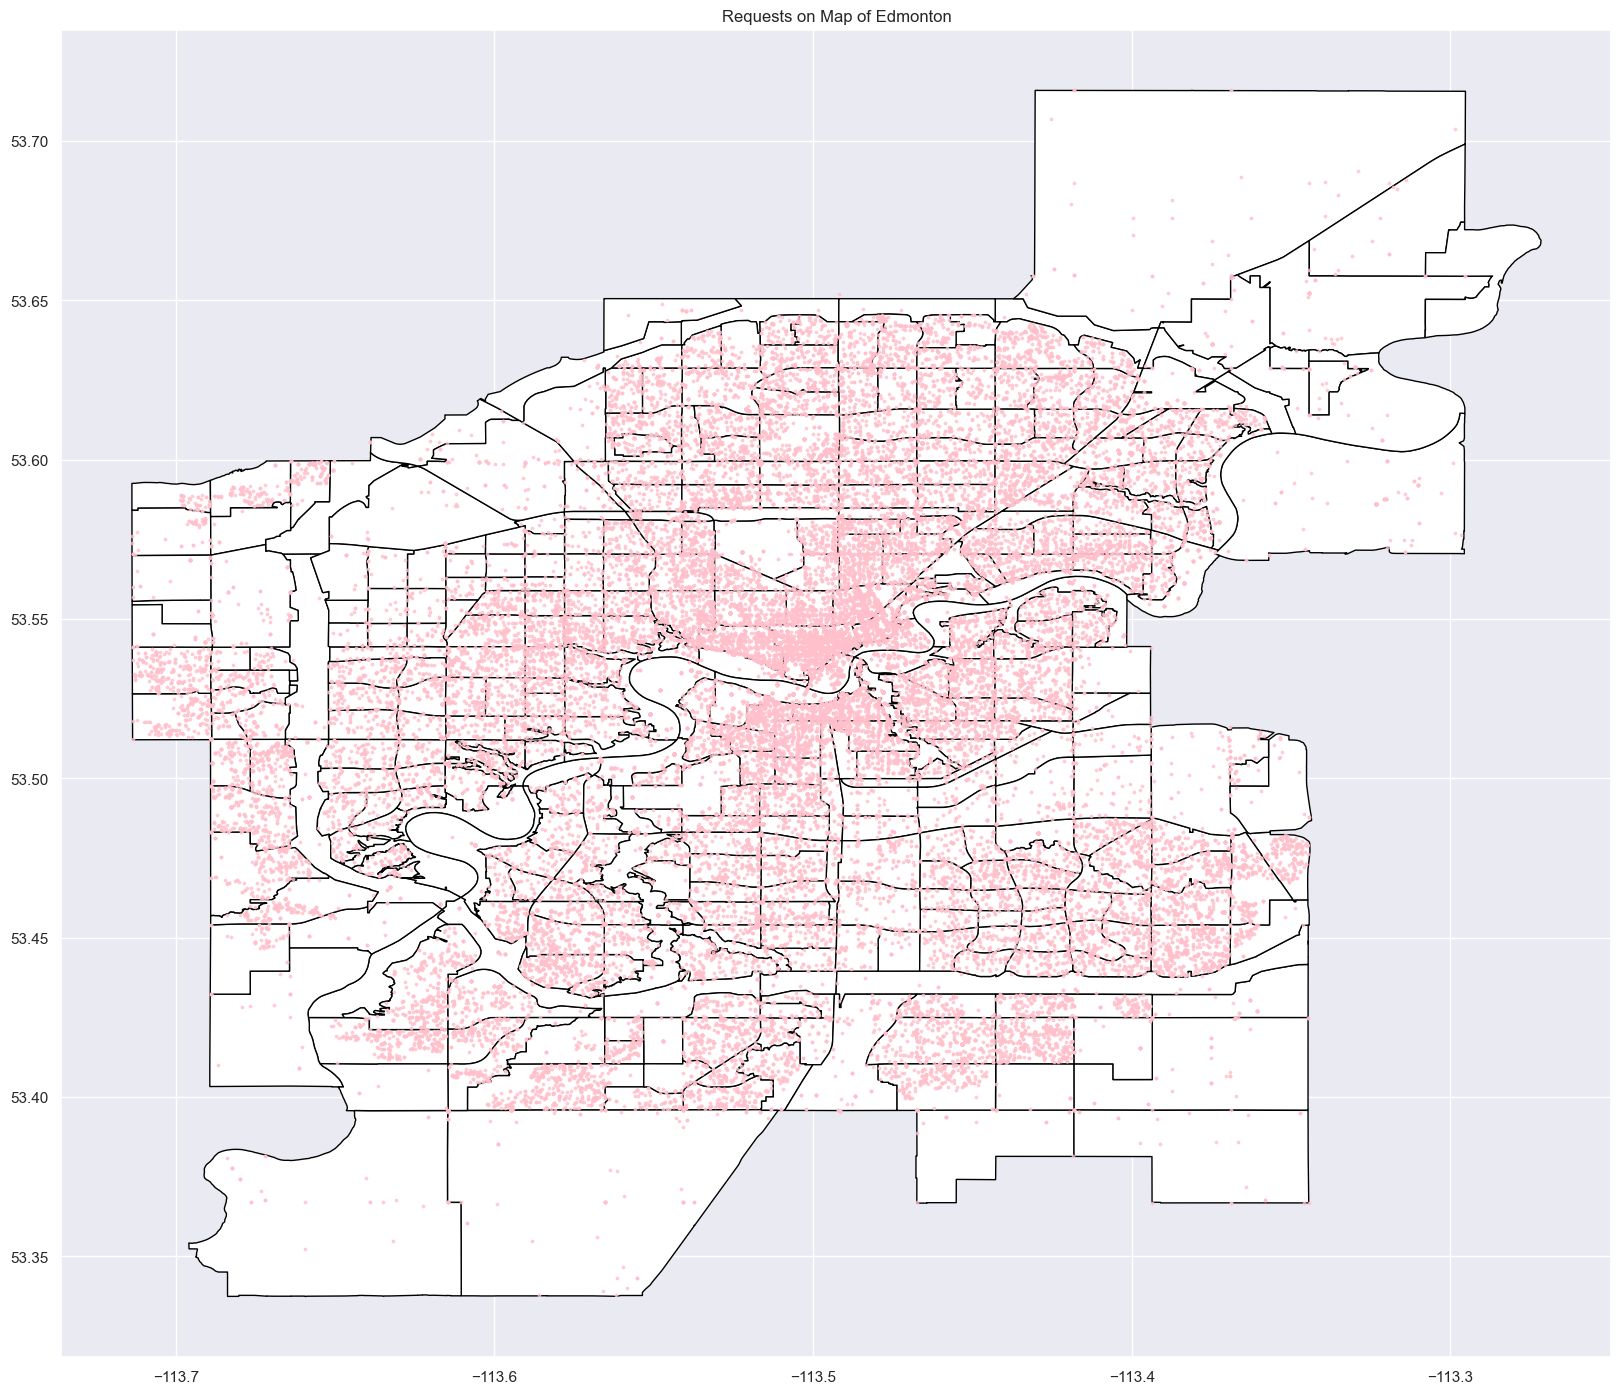

In [26]:
# Load Edmonton boundary shapefile
edmonton_boundary = gpd.read_file('..\shape-files\edmonton_neighbourhoods.shp')

# Create a GeoDataFrame with data
gdf = gpd.GeoDataFrame(data[data['Request Year']==2024], geometry=gpd.points_from_xy(data[data['Request Year']==2024]['Long'], data[data['Request Year']==2024]['Lat']))

# Plot
fig, ax = plt.subplots(figsize=(20, 20))
edmonton_boundary.plot(ax=ax, color='white', edgecolor='black')

# Plot requests with adjusted markers
gdf.plot(ax=ax, markersize=3, color='pink', alpha=0.7, legend=True)

plt.title('Requests on Map of Edmonton')
plt.show()


Word Cloud of Service Catgory

In [ ]:
!pip install wordcloud
from wordcloud import WordCloud

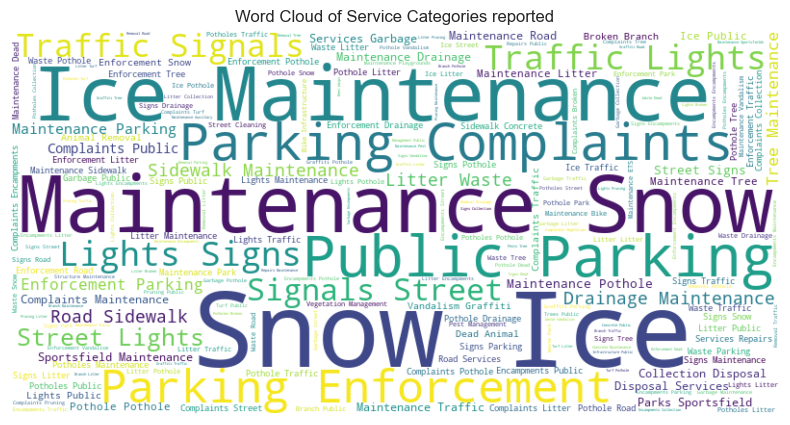

In [28]:
df = data['Service Category']

df = pd.DataFrame(df)

text = ' '.join(df['Service Category'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

#plotting the word cloud

plt.figure(figsize=(10,5))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Service Categories reported")
plt.show()

In [ ]:
df = data['Neighbourhood']
df = pd.DataFrame(df)

# Drop any missing values
df = df.dropna()

# Directly use the column for counting phrases
phrase_series = df['Neighbourhood']

# Get phrase frequencies using value_counts
phrase_freq = phrase_series.value_counts()

# Convert to DataFrame for better visualization
phrase_freq_df = phrase_freq.reset_index()
phrase_freq_df.columns = ['Phrase', 'Frequency']
phrase_freq_df = phrase_freq_df.sort_values(by='Frequency', ascending=False)

# Generate the word cloud based on phrase frequencies
wordcloud = WordCloud(background_color='black', colormap='viridis').generate_from_frequencies(phrase_freq)

# Plot the word cloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Neighbourhoods")
plt.show()



### Using neighbourhoods file to create Edmonton neighbourhoods boundaries for analyis

In [180]:

#Loading the data
edmonton = pd.read_csv('../data/neighbourhoods-data.csv',sep=',')

# Convert 'Geometry Multipolygon' from WKT to Shapely geometries
edmonton['Geometry Multipolygon'] = edmonton['Geometry Multipolygon'].apply(convert_to_geometry)

#creating a GeoDataframe
edmonton_gdf = gpd.GeoDataFrame(edmonton,geometry='Geometry Multipolygon')

#setting the coordinate reference system (CRS)
edmonton_gdf.set_crs(epsg=32612,inplace=True)

#saving it as a shape file
edmonton_gdf.to_file('../shape-files/edmonton_neighbourhoods.shp'
                     )

In [181]:
data[['Date Created','Date Closed']] = data[['Date Created','Date Closed']].astype('str')

In [182]:
# Group by 'Date Created' and 'Neighbourhood' and count the occurrences
neighbourhood_wise = data.groupby(by=['Date Created', 'Neighbourhood']).size().reset_index(name='Count')

# Pivot the DataFrame to have 'Date Created' as columns and 'Neighbourhood' as index
neighbourhood_wise_pivot = neighbourhood_wise.pivot_table(index='Neighbourhood', columns='Date Created', values='Count', fill_value=0)
neighbourhood_wise_pivot


Date Created,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2024-07-14,2024-07-15,2024-07-16,2024-07-17,2024-07-18,2024-07-19,2024-07-20,2024-07-21,2024-07-22,2024-07-23
Neighbourhood,,,,,,,,,,,,,,,,,,,,,
ABBOTTSFIELD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0
ALBANY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
ALBERTA AVENUE,0.0,3.0,6.0,2.0,1.0,4.0,3.0,1.0,1.0,1.0,...,4.0,0.0,5.0,3.0,7.0,3.0,1.0,2.0,6.0,7.0
ALBERTA PARK INDUSTRIAL,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
ALCES,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WOODCROFT,0.0,4.0,3.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0
YELLOWHEAD CORRIDOR EAST,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0
YELLOWHEAD CORRIDOR WEST,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [183]:
type(edmonton_gdf)

geopandas.geodataframe.GeoDataFrame

In [184]:
edmonton_gdf.head(10)

,Neighbourhood Name,Neighbourhood Number,Descriptive Name,Description,Effective Start Date,Effective End Date,Civic Ward,Planning District,Geometry Multipolygon
0,ABBOTTSFIELD,2010,Abbottsfield,"Abbottsfield was once owned by E.F. Carey, one...",1981-10-01,NaN,Métis,118 Avenue,"MULTIPOLYGON (((-113.388 53.576, -113.389 53.5..."
1,ALBANY,3460,Albany,NaN,2011-06-13,NaN,Anirniq,Northwest,"MULTIPOLYGON (((-113.560 53.632, -113.562 53.6..."
2,ALBERTA AVENUE,1010,Alberta Avenue,One of the city's older residential neighbourh...,1981-10-01,NaN,Métis,118 Avenue,"MULTIPOLYGON (((-113.492 53.577, -113.492 53.5..."
3,ALBERTA PARK INDUSTRIAL,4010,Alberta Park Industrial,This non-residential neighbourhood is largely ...,1981-10-01,NaN,Nakota Isga,Jasper Place,"MULTIPOLYGON (((-113.590 53.567, -113.590 53.5..."
4,ALCES,6669,Alces,Formerly Decoteau North,2019-07-25,NaN,Sspomitapi,NaN,"MULTIPOLYGON (((-113.376 53.425, -113.369 53.4..."
5,ALDERGROVE,4020,Aldergrove,"Planned in the 1970s, this area's multi-family...",1981-10-01,NaN,Nakota Isga,West Edmonton,"MULTIPOLYGON (((-113.652 53.520, -113.652 53.5..."
6,ALLARD,5458,Allard,NaN,2011-07-18,NaN,Ipiihkoohkanipiaohtsi,Southwest,"MULTIPOLYGON (((-113.517 53.407, -113.518 53.4..."
7,ALLENDALE,5010,Allendale,"Once farmed by the Allen family, this area was...",1981-10-01,NaN,papastew,Scona,"MULTIPOLYGON (((-113.503 53.506, -113.503 53.5..."
8,AMBLESIDE,5505,Ambleside,The name Ambleside most likely originates from...,2007-07-19,NaN,pihêsiwin,Southwest,"MULTIPOLYGON (((-113.570 53.425, -113.570 53.4..."
9,ANTHONY HENDAY,4011,Anthony Henday,This non-residential neighbourhood forms part ...,1981-10-01,NaN,Nakota Isga,West Henday,"MULTIPOLYGON (((-113.665 53.525, -113.666 53.5..."


In [185]:
edmonton_gdf = edmonton_gdf.rename(columns={
    'Neighbourhood Name':'Neighbourhood'
})

In [186]:
edmonton_gdf = edmonton_gdf[['Neighbourhood','Geometry Multipolygon']]

In [187]:
edmonton_gdf

,Neighbourhood,Geometry Multipolygon
0,ABBOTTSFIELD,"MULTIPOLYGON (((-113.388 53.576, -113.389 53.5..."
1,ALBANY,"MULTIPOLYGON (((-113.560 53.632, -113.562 53.6..."
2,ALBERTA AVENUE,"MULTIPOLYGON (((-113.492 53.577, -113.492 53.5..."
3,ALBERTA PARK INDUSTRIAL,"MULTIPOLYGON (((-113.590 53.567, -113.590 53.5..."
4,ALCES,"MULTIPOLYGON (((-113.376 53.425, -113.369 53.4..."
...,...,...
398,WOODCROFT,"MULTIPOLYGON (((-113.566 53.569, -113.566 53.5..."
399,YELLOWHEAD CORRIDOR EAST,"MULTIPOLYGON (((-113.445 53.584, -113.445 53.5..."
400,YELLOWHEAD CORRIDOR WEST,"MULTIPOLYGON (((-113.492 53.585, -113.494 53.5..."
401,YORK,"MULTIPOLYGON (((-113.429 53.607, -113.430 53.6..."


In [188]:
edmonton_gdf.shape

(403, 2)

In [189]:
data['Neighbourhood'].nunique()

403

In [190]:
for name in data['Neighbourhood'].unique():
    if name not in edmonton_gdf['Neighbourhood'].unique():
        print(name)

In [191]:
neighbourhood_wise_pivot.columns

Index(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04', '2014-01-05',
       '2014-01-06', '2014-01-07', '2014-01-08', '2014-01-09', '2014-01-10',
       ...
       '2024-07-14', '2024-07-15', '2024-07-16', '2024-07-17', '2024-07-18',
       '2024-07-19', '2024-07-20', '2024-07-21', '2024-07-22', '2024-07-23'],
      dtype='object', name='Date Created', length=3857)

In [192]:
#merging the 'neighbourhood_wise_pivot' with 'edmonton boundaries data'
merge = edmonton_gdf.join(neighbourhood_wise_pivot,on='Neighbourhood',how='right')
merge

,Neighbourhood,Geometry Multipolygon,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2024-07-14,2024-07-15,2024-07-16,2024-07-17,2024-07-18,2024-07-19,2024-07-20,2024-07-21,2024-07-22,2024-07-23
0,ABBOTTSFIELD,"MULTIPOLYGON (((-113.388 53.576, -113.389 53.5...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0
1,ALBANY,"MULTIPOLYGON (((-113.560 53.632, -113.562 53.6...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,ALBERTA AVENUE,"MULTIPOLYGON (((-113.492 53.577, -113.492 53.5...",0.0,3.0,6.0,2.0,1.0,4.0,3.0,1.0,...,4.0,0.0,5.0,3.0,7.0,3.0,1.0,2.0,6.0,7.0
3,ALBERTA PARK INDUSTRIAL,"MULTIPOLYGON (((-113.590 53.567, -113.590 53.5...",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,ALCES,"MULTIPOLYGON (((-113.376 53.425, -113.369 53.4...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,WOODCROFT,"MULTIPOLYGON (((-113.566 53.569, -113.566 53.5...",0.0,4.0,3.0,0.0,2.0,2.0,0.0,0.0,...,0.0,1.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0
399,YELLOWHEAD CORRIDOR EAST,"MULTIPOLYGON (((-113.445 53.584, -113.445 53.5...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0
400,YELLOWHEAD CORRIDOR WEST,"MULTIPOLYGON (((-113.492 53.585, -113.494 53.5...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
401,YORK,"MULTIPOLYGON (((-113.429 53.607, -113.430 53.6...",0.0,3.0,2.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [193]:
merge.columns

Index(['Neighbourhood', 'Geometry Multipolygon', '2014-01-01', '2014-01-02',
       '2014-01-03', '2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
       '2014-01-08',
       ...
       '2024-07-14', '2024-07-15', '2024-07-16', '2024-07-17', '2024-07-18',
       '2024-07-19', '2024-07-20', '2024-07-21', '2024-07-22', '2024-07-23'],
      dtype='object', length=3859)

In [194]:
dates = merge.columns.to_list()

In [195]:
len(dates)

3859

In [196]:
len(dates[3654:3655])

1

In [197]:
for dates in merge.columns.to_list()[2:10]:
    print(merge.columns)

Index(['Neighbourhood', 'Geometry Multipolygon', '2014-01-01', '2014-01-02',
       '2014-01-03', '2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
       '2014-01-08',
       ...
       '2024-07-14', '2024-07-15', '2024-07-16', '2024-07-17', '2024-07-18',
       '2024-07-19', '2024-07-20', '2024-07-21', '2024-07-22', '2024-07-23'],
      dtype='object', length=3859)
Index(['Neighbourhood', 'Geometry Multipolygon', '2014-01-01', '2014-01-02',
       '2014-01-03', '2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
       '2014-01-08',
       ...
       '2024-07-14', '2024-07-15', '2024-07-16', '2024-07-17', '2024-07-18',
       '2024-07-19', '2024-07-20', '2024-07-21', '2024-07-22', '2024-07-23'],
      dtype='object', length=3859)
Index(['Neighbourhood', 'Geometry Multipolygon', '2014-01-01', '2014-01-02',
       '2014-01-03', '2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
       '2014-01-08',
       ...
       '2024-07-14', '2024-07-15', '2024-07-16', '2024-07-17',

In [255]:
from textwrap import wrap

def wrap_text(text, width):
    """Wrap text to fit within the specified width."""
    return '\n'.join(wrap(text, width))

# Create an empty list to store image frames
image_frames = []

# Loop through each date column and plot the data
for dates in merge.columns.to_list()[3654:3655]:
    
    fig, ax = plt.subplots(figsize=(15 ,15))
    merge.plot(column=dates,
               cmap='Reds',  # Colormap
               ax=ax,
               legend=False,
               edgecolor='black',
               linewidth=0.4)

    # Add title and remove axis
    ax.set_title('City of Edmonton \n 311 Requests recieved on ' + dates)

    # Sort neighborhoods by request counts for the current date and select top 20
    top_neighborhoods = merge.sort_values(by=dates, ascending=False).head(20)

    # Add top 20 neighborhood names as text annotations
    for _, row in top_neighborhoods.iterrows():
        if pd.notna(row[dates]):  # Ensure there's data for this date
            x, y = row['Geometry Multipolygon'].centroid.xy
            
            # Wrap the text to fit better within the bounds
            wrapped_text = wrap_text(row['Neighbourhood'], width=15)  # Adjust width as needed
            
            ax.text(x[0], y[0], wrapped_text,
                    fontsize=8,  # Adjust font size as needed
                    ha='center', va='center',
                    color='black', weight='normal',
                    bbox=dict(facecolor=None, edgecolor='none', alpha=0))  # No background color

    ax.set_axis_off()

    # Save the plot to a BytesIO object
    f = io.BytesIO()
    plt.savefig(f, format='png', bbox_inches='tight')
    f.seek(0)
    image_frames.append(PIL.Image.open(f))
    
# Save all the images as a GIF file
image_frames[0].save('Dynamic_311_Requests.gif', format='GIF',
                     append_images=image_frames[1:],
                     save_all=True,
                     duration=1000,  # Duration of each frame in milliseconds
                     loop=0)
f.close()
plt.close(ax.figure)  # Close the figure to avoid memory issues